In [1]:
import pickle
from pathlib import Path
from tqdm.auto import tqdm, trange

from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_1samp
import numpy as np, pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# path2dir = Path('/work/magroup/hanzhan4/model_output/hcformer_pbulk')
path2dir = Path('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk')
with open(path2dir / 'baseline/baseline_test_ahr49sz0.pkl', 'rb') as f:
    baseline_test_output = pickle.load(f).numpy()
with open(path2dir / 'baseline/baseline_valid_ahr49sz0.pkl', 'rb') as f:
    baseline_valid_output = pickle.load(f).numpy()

with open(path2dir / 'hic1d2d/hic1d2d_test_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_test_output = pickle.load(f).numpy()
with open(path2dir / 'hic1d2d/hic1d2d_valid_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_valid_output = pickle.load(f).numpy()

# do not need to modify
with open(path2dir / 'test_expression.pkl', 'rb') as f:
    test_exp = pickle.load(f).numpy()

with open(path2dir / 'valid_expression.pkl', 'rb') as f:
    valid_exp = pickle.load(f).numpy()

In [3]:
baseline_test_output.shape, hic1d2d_test_output.shape, test_exp.shape

((4488, 240, 1), (4488, 240, 1), (4488, 240, 1))

In [4]:
shape = (6, 748, 240)
def fn(x):
    return x.reshape(6, 748, 240).transpose(1, 0, 2).reshape(748, 6 * 240)
corr_1d2d = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn(hic1d2d_test_output), fn(test_exp)))])
corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn(baseline_test_output), fn(test_exp)))])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
corr_1d2d.mean(), corr_baseline.mean()

(0.3792799557632494, 0.33470103897671794)

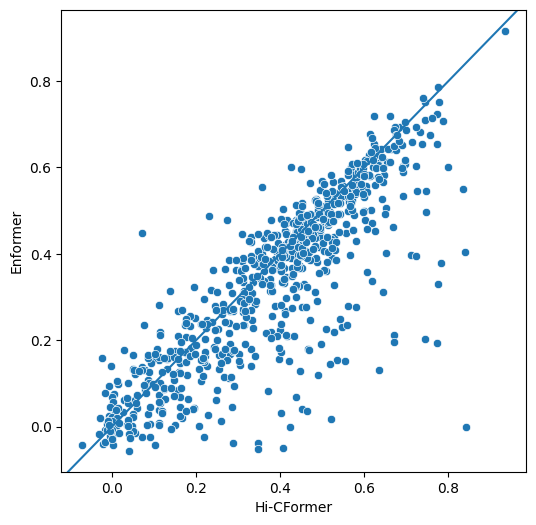

In [6]:
x, y = corr_1d2d, corr_baseline
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(ax=ax, x=x, y=y)
ax.axline((0, 0), slope=1)
ax.set(xlabel='Hi-CFormer', ylabel='Enformer')
plt.show()
plt.close('all')

In [7]:
# path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC')
path2dir = Path('/home/ubuntu/SeqHiC2RNA/data')
df_gene = pd.read_csv(path2dir / 'genes.tsv', sep='\t').iloc[2992:]
df_tfbs = pd.read_csv(path2dir / 'tfbs' / 'hit_r1000_dboth_thr0.csv.gz')
df_tfbs = df_tfbs[df_tfbs.gene_id.isin(df_gene.gene_id)]

In [8]:
df = df_tfbs.set_index(['gene_id', 'tf_name']).hit.unstack().fillna(0).astype(int).loc[df_gene.gene_id]

In [9]:
corr_diff = corr_1d2d - corr_baseline

In [10]:
x = corr_diff
y = df.values
df_test = pd.DataFrame([
    pearsonr(x, _)
    for _ in tqdm(y.T)
], index=df.columns)

  0%|          | 0/251 [00:00<?, ?it/s]

<Axes: xlabel='statistic', ylabel='Count'>

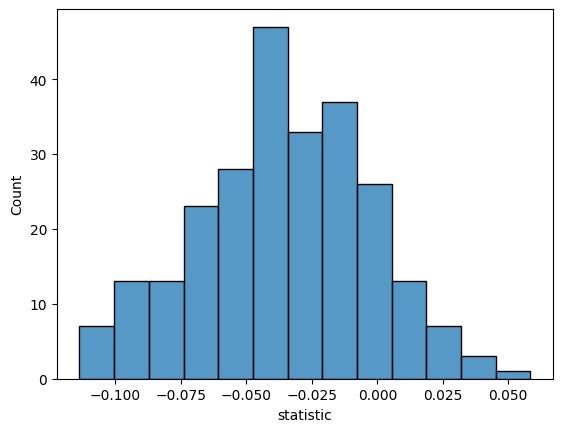

In [12]:
sns.histplot(df_test.statistic)

In [13]:
ttest_1samp(df_test.statistic, 0)

TtestResult(statistic=-17.36114905594502, pvalue=7.77136587075766e-45, df=250)

In [14]:
corr_diff = corr_1d2d + corr_baseline

In [15]:
x = corr_diff
y = df.values
df_test = pd.DataFrame([
    pearsonr(x, _)
    for _ in tqdm(y.T)
], index=df.columns)

  0%|          | 0/251 [00:00<?, ?it/s]

<Axes: xlabel='statistic', ylabel='Count'>

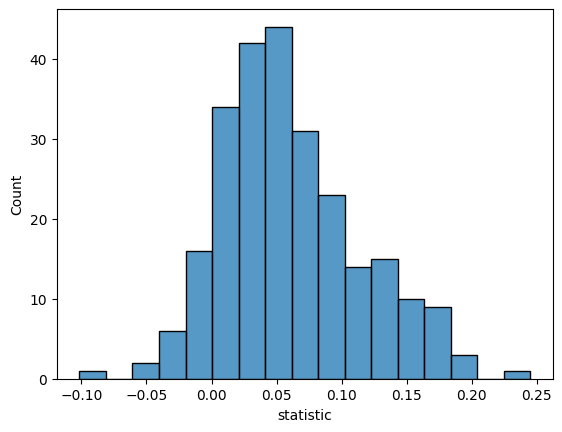

In [16]:
sns.histplot(df_test.statistic)

In [17]:
ttest_1samp(df_test.statistic, 0)

TtestResult(statistic=17.503842017462123, pvalue=2.5195293726967385e-45, df=250)

In [18]:
mask = df_test.pvalue < 1e-3
print(mask.sum())
x = corr_diff
y = df.values[:, mask].mean(1)
pearsonr(x, y)

39


PearsonRResult(statistic=0.3140150383704138, pvalue=1.4014865118641778e-18)

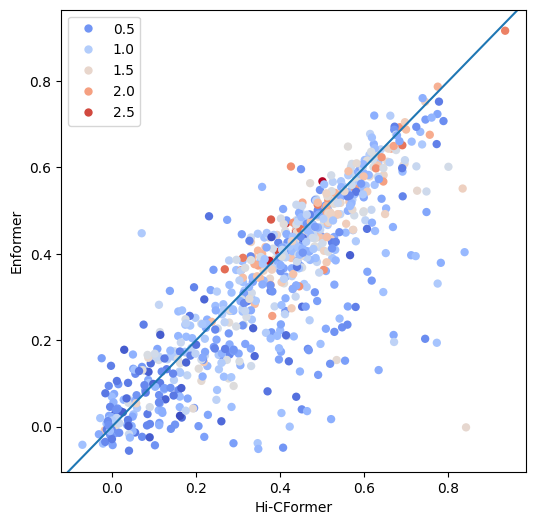

In [19]:
x, y = corr_1d2d, corr_baseline
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(ax=ax, x=x, y=y, hue=np.log1p(df.values[:, mask].mean(1)), edgecolor='none', palette='coolwarm')
ax.axline((0, 0), slope=1)
ax.set(xlabel='Hi-CFormer', ylabel='Enformer')
plt.show()
plt.close('all')

# Using GO Analysis

In [27]:
import os

# Convert Gene ID to gene name
data_path = '/home/ubuntu/SeqHiC2RNA/data'
gene_name = pd.read_csv(os.path.join(data_path, 'gene_id_conversion.tsv'), sep='\t', names=['gene_id', 'gene_name', 'other'])
df_gene = df_gene.merge(gene_name[['gene_id', 'gene_name']], how='left', on='gene_id')

# Get reference gene name
test_gene_name = df_gene['gene_name']
total_df_gene = pd.read_csv(os.path.join(path2dir, 'genes.tsv'), sep='\t')
total_df_gene = total_df_gene.merge(gene_name[['gene_id', 'gene_name']], how='left', on='gene_id')
total_gene_name = total_df_gene['gene_name']


In [29]:
# Select genes
# /**to do**/
select_gene_id = np.random.choice(748, 10, replace=False)
# /**to do**/
 
select_gene_name = df_gene['gene_name'].iloc[select_gene_id]

In [32]:
# save gene name to csv
go_analysis_path = './go_analysis'
select_gene_name.to_csv(os.path.join(go_analysis_path, 'select_gene_name.txt'), sep='\t', index=False, header=False)
test_gene_name.to_csv(os.path.join(go_analysis_path, 'test_gene_name.txt'), sep='\t', index=False, header=False)
total_gene_name.to_csv(os.path.join(go_analysis_path, 'total_gene_name.txt'), sep='\t', index=False, header=False)


In [36]:
import subprocess

bash_script = """
path=./go_analysis
for domain in BP CC MF; do
        python pthr_go_annots.py --service enrich --params_file $path/enrich_${domain}.json \
            --seq_id_file $path/select_gene_name.txt --ref_seq_id_file $path/test_gene_name.txt \
            > $path/go_output_${domain}.txt
done
"""

subprocess.run(bash_script, shell=True, check=True)


CompletedProcess(args='\npath=./go_analysis\nfor domain in BP CC MF; do\n        python pthr_go_annots.py --service enrich --params_file $path/enrich_${domain}.json             --seq_id_file $path/select_gene_name.txt --ref_seq_id_file $path/test_gene_name.txt             > $path/go_output_${domain}.txt\ndone\n', returncode=0)